In [1]:
import torch
import numpy as np
import data
import tqdm
import autoencoder_resnet_simple
import models
from torchvision.transforms import v2

/home/anirudh/Documents/GSoC/DeepLense/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 32
EPOCHS = 200
LATENT_DIM = 512
LR = 5e-5
in_shape = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def transform():
    """
    Data augmentation by random rotation, and random scaling between 0.8 to 1.2

    :return: RandomAffine module that performs the transformation 
    """
    return v2.RandomAffine(degrees=(-180,180),scale=(0.8,1.2))

In [3]:
train_dataset = data.LensingDataset('index.csv','../dataset/train/',transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [4]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        """
        Assembly of the autoencoder loaded with pretrained weights, the physics-informer and the classifier
        """
        super(Model, self).__init__()
        self.autoencoder = autoencoder_resnet_simple.AutoEncoder(dropout=0.1)
        self.autoencoder.load_state_dict(torch.load('autoencoder_simple_state_512.pt'))
        self.informer = models.LensAutoEncoder(in_shape=in_shape,device=device)
        self.classifier = models.Resnet_simple()
    
    def forward(self, x):
        """
        Forward propagation

        :param x: Image to be classified
        :return: Predicted class
        """
        k = self.autoencoder(x)
        x = self.informer(k, x)
        x = self.classifier(x)
        return x

In [5]:
model = Model().to(device)

accs = []
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(),lr=LR)
best_val_loss = np.inf
best_weights = None
history = {'val_loss':[], 'loss':[], 'acc':[]}
for epoch in range(EPOCHS):
    losses = []
    model.train()
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        loss = loss_fn(x,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(loss))
        accs.append(float(acc))
    print("Training at epoch %d/%d: %.4f with acc=%.5f at LR=%.6f"%(epoch+1,EPOCHS,np.mean(losses),np.mean(accs),opt.param_groups[0]['lr']))
    history['loss'].append(np.mean(losses))
    train_loss = np.mean(losses)
    model.eval()
    losses = []
    accs = []
    for i,(x,y) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(val_loss))
        accs.append(float(acc))
    history['val_loss'].append(np.mean(losses))
    history['acc'].append(np.mean(accs))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = model.state_dict()
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} with acc={np.mean(accs)} at LR={opt.param_groups[0]['lr']}")


Training epoch 0: 100%|██████████| 938/938 [01:05<00:00, 14.25it/s]


Training at epoch 1/200: 1.1179 with acc=0.33679 at LR=0.000050


Validation epoch 0: 100%|██████████| 235/235 [00:09<00:00, 26.04it/s]


Validation at epoch 1/200: 1.101395369590597 with acc=0.34995567375886527 at LR=5e-05


Training epoch 1: 100%|██████████| 938/938 [01:03<00:00, 14.69it/s]


Training at epoch 2/200: 1.1044 with acc=0.34720 at LR=0.000050


Validation epoch 1: 100%|██████████| 235/235 [00:09<00:00, 25.79it/s]


Validation at epoch 2/200: 1.1302582953838591 with acc=0.3358599290780142 at LR=5e-05


Training epoch 2: 100%|██████████| 938/938 [01:03<00:00, 14.69it/s]


Training at epoch 3/200: 1.0876 with acc=0.37595 at LR=0.000050


Validation epoch 2: 100%|██████████| 235/235 [00:09<00:00, 25.99it/s]


Validation at epoch 3/200: 1.2071978959631413 with acc=0.33328900709219855 at LR=5e-05


Training epoch 3: 100%|██████████| 938/938 [01:03<00:00, 14.68it/s]


Training at epoch 4/200: 1.0617 with acc=0.41422 at LR=0.000050


Validation epoch 3: 100%|██████████| 235/235 [00:09<00:00, 26.05it/s]


Validation at epoch 4/200: 1.202883717100671 with acc=0.3406028368794326 at LR=5e-05


Training epoch 4: 100%|██████████| 938/938 [01:03<00:00, 14.72it/s]


Training at epoch 5/200: 1.0412 with acc=0.43682 at LR=0.000050


Validation epoch 4: 100%|██████████| 235/235 [00:08<00:00, 26.20it/s]


Validation at epoch 5/200: 1.1404082909543463 with acc=0.38812056737588657 at LR=5e-05


Training epoch 5: 100%|██████████| 938/938 [01:03<00:00, 14.69it/s]


Training at epoch 6/200: 1.0237 with acc=0.46839 at LR=0.000050


Validation epoch 5: 100%|██████████| 235/235 [00:09<00:00, 26.06it/s]


Validation at epoch 6/200: 1.1438016057014466 with acc=0.3913120567375887 at LR=5e-05


Training epoch 6: 100%|██████████| 938/938 [01:03<00:00, 14.72it/s]


Training at epoch 7/200: 1.0095 with acc=0.48196 at LR=0.000050


Validation epoch 6: 100%|██████████| 235/235 [00:08<00:00, 26.40it/s]


Validation at epoch 7/200: 1.1326878405631857 with acc=0.3990248226950355 at LR=5e-05


Training epoch 7: 100%|██████████| 938/938 [01:03<00:00, 14.73it/s]


Training at epoch 8/200: 0.9967 with acc=0.49810 at LR=0.000050


Validation epoch 7: 100%|██████████| 235/235 [00:08<00:00, 26.90it/s]


Validation at epoch 8/200: 1.11882344027783 with acc=0.41458333333333336 at LR=5e-05


Training epoch 8: 100%|██████████| 938/938 [01:03<00:00, 14.77it/s]


Training at epoch 9/200: 0.9842 with acc=0.51406 at LR=0.000050


Validation epoch 8: 100%|██████████| 235/235 [00:08<00:00, 26.27it/s]


Validation at epoch 9/200: 1.1228515335854063 with acc=0.41697695035460997 at LR=5e-05


Training epoch 9: 100%|██████████| 938/938 [01:03<00:00, 14.73it/s]


Training at epoch 10/200: 0.9730 with acc=0.52501 at LR=0.000050


Validation epoch 9: 100%|██████████| 235/235 [00:08<00:00, 26.78it/s]


Validation at epoch 10/200: 1.113972690764894 with acc=0.42039007092198577 at LR=5e-05


Training epoch 10: 100%|██████████| 938/938 [01:03<00:00, 14.75it/s]


Training at epoch 11/200: 0.9648 with acc=0.53158 at LR=0.000050


Validation epoch 10: 100%|██████████| 235/235 [00:08<00:00, 26.70it/s]


Validation at epoch 11/200: 1.1506844941605914 with acc=0.3918439716312057 at LR=5e-05


Training epoch 11: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 12/200: 0.9605 with acc=0.53066 at LR=0.000050


Validation epoch 11: 100%|██████████| 235/235 [00:08<00:00, 26.69it/s]


Validation at epoch 12/200: 1.0984417291397743 with acc=0.43905141843971635 at LR=5e-05


Training epoch 12: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]


Training at epoch 13/200: 0.9540 with acc=0.54869 at LR=0.000050


Validation epoch 12: 100%|██████████| 235/235 [00:08<00:00, 26.54it/s]


Validation at epoch 13/200: 1.1126770762687033 with acc=0.4300975177304964 at LR=5e-05


Training epoch 13: 100%|██████████| 938/938 [01:03<00:00, 14.78it/s]


Training at epoch 14/200: 0.9460 with acc=0.55305 at LR=0.000050


Validation epoch 13: 100%|██████████| 235/235 [00:08<00:00, 26.17it/s]


Validation at epoch 14/200: 1.0700675020826624 with acc=0.4696365248226951 at LR=5e-05


Training epoch 14: 100%|██████████| 938/938 [01:03<00:00, 14.80it/s]


Training at epoch 15/200: 0.9409 with acc=0.56553 at LR=0.000050


Validation epoch 14: 100%|██████████| 235/235 [00:08<00:00, 26.62it/s]


Validation at epoch 15/200: 1.1457807525675348 with acc=0.39822695035461 at LR=5e-05


Training epoch 15: 100%|██████████| 938/938 [01:03<00:00, 14.79it/s]


Training at epoch 16/200: 0.9318 with acc=0.55972 at LR=0.000050


Validation epoch 15: 100%|██████████| 235/235 [00:08<00:00, 26.47it/s]


Validation at epoch 16/200: 1.0809788483254452 with acc=0.45815602836879427 at LR=5e-05


Training epoch 16: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]


Training at epoch 17/200: 0.9277 with acc=0.57530 at LR=0.000050


Validation epoch 16: 100%|██████████| 235/235 [00:08<00:00, 26.42it/s]


Validation at epoch 17/200: 1.0973538127351314 with acc=0.44250886524822697 at LR=5e-05


Training epoch 17: 100%|██████████| 938/938 [01:04<00:00, 14.63it/s]


Training at epoch 18/200: 0.9209 with acc=0.57520 at LR=0.000050


Validation epoch 17: 100%|██████████| 235/235 [00:08<00:00, 26.53it/s]


Validation at epoch 18/200: 1.0783744672511486 with acc=0.46161347517730494 at LR=5e-05


Training epoch 18: 100%|██████████| 938/938 [01:03<00:00, 14.66it/s]


Training at epoch 19/200: 0.9164 with acc=0.58457 at LR=0.000050


Validation epoch 18: 100%|██████████| 235/235 [00:08<00:00, 26.39it/s]


Validation at epoch 19/200: 1.048110580444336 with acc=0.4867021276595745 at LR=5e-05


Training epoch 19: 100%|██████████| 938/938 [01:04<00:00, 14.60it/s]


Training at epoch 20/200: 0.9095 with acc=0.59751 at LR=0.000050


Validation epoch 19: 100%|██████████| 235/235 [00:08<00:00, 26.30it/s]


Validation at epoch 20/200: 1.0955612700036232 with acc=0.4459219858156028 at LR=5e-05


Training epoch 20: 100%|██████████| 938/938 [01:03<00:00, 14.70it/s]


Training at epoch 21/200: 0.9048 with acc=0.59349 at LR=0.000050


Validation epoch 20: 100%|██████████| 235/235 [00:08<00:00, 26.69it/s]


Validation at epoch 21/200: 1.0236129466523516 with acc=0.5170212765957447 at LR=5e-05


Training epoch 21: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s]


Training at epoch 22/200: 0.8999 with acc=0.61019 at LR=0.000050


Validation epoch 21: 100%|██████████| 235/235 [00:08<00:00, 26.97it/s]


Validation at epoch 22/200: 1.0123992648530513 with acc=0.5270833333333333 at LR=5e-05


Training epoch 22: 100%|██████████| 938/938 [01:03<00:00, 14.79it/s]


Training at epoch 23/200: 0.8951 with acc=0.61852 at LR=0.000050


Validation epoch 22: 100%|██████████| 235/235 [00:09<00:00, 25.32it/s]


Validation at epoch 23/200: 1.0101836747311532 with acc=0.5245567375886525 at LR=5e-05


Training epoch 23: 100%|██████████| 938/938 [01:05<00:00, 14.37it/s]


Training at epoch 24/200: 0.8870 with acc=0.62377 at LR=0.000050


Validation epoch 23: 100%|██████████| 235/235 [00:09<00:00, 25.84it/s]


Validation at epoch 24/200: 1.0966870526049999 with acc=0.4473404255319149 at LR=5e-05


Training epoch 24: 100%|██████████| 938/938 [01:04<00:00, 14.48it/s]


Training at epoch 25/200: 0.8844 with acc=0.61155 at LR=0.000050


Validation epoch 24: 100%|██████████| 235/235 [00:09<00:00, 25.45it/s]


Validation at epoch 25/200: 1.0465305310614565 with acc=0.49361702127659574 at LR=5e-05


Training epoch 25: 100%|██████████| 938/938 [01:03<00:00, 14.70it/s]


Training at epoch 26/200: 0.8754 with acc=0.62860 at LR=0.000050


Validation epoch 25: 100%|██████████| 235/235 [00:08<00:00, 26.89it/s]


Validation at epoch 26/200: 0.9693957166468844 with acc=0.5654255319148936 at LR=5e-05


Training epoch 26: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 27/200: 0.8739 with acc=0.64437 at LR=0.000050


Validation epoch 26: 100%|██████████| 235/235 [00:08<00:00, 27.30it/s]


Validation at epoch 27/200: 1.0151868827799533 with acc=0.5277925531914893 at LR=5e-05


Training epoch 27: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 28/200: 0.8708 with acc=0.63851 at LR=0.000050


Validation epoch 27: 100%|██████████| 235/235 [00:08<00:00, 27.46it/s]


Validation at epoch 28/200: 0.9142644146655469 with acc=0.6227393617021276 at LR=5e-05


Training epoch 28: 100%|██████████| 938/938 [01:02<00:00, 15.08it/s]


Training at epoch 29/200: 0.8660 with acc=0.66312 at LR=0.000050


Validation epoch 28: 100%|██████████| 235/235 [00:08<00:00, 27.32it/s]


Validation at epoch 29/200: 0.9903061280859278 with acc=0.5477836879432625 at LR=5e-05


Training epoch 29: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


Training at epoch 30/200: 0.8619 with acc=0.65080 at LR=0.000050


Validation epoch 29: 100%|██████████| 235/235 [00:08<00:00, 27.21it/s]


Validation at epoch 30/200: 0.9458193941319243 with acc=0.5914007092198582 at LR=5e-05


Training epoch 30: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]


Training at epoch 31/200: 0.8601 with acc=0.66132 at LR=0.000050


Validation epoch 30: 100%|██████████| 235/235 [00:08<00:00, 27.48it/s]


Validation at epoch 31/200: 0.9210352134197316 with acc=0.6200797872340426 at LR=5e-05


Training epoch 31: 100%|██████████| 938/938 [01:01<00:00, 15.13it/s]


Training at epoch 32/200: 0.8536 with acc=0.67303 at LR=0.000050


Validation epoch 31: 100%|██████████| 235/235 [00:08<00:00, 27.32it/s]


Validation at epoch 32/200: 0.9689650261655767 with acc=0.5720301418439715 at LR=5e-05


Training epoch 32: 100%|██████████| 938/938 [01:02<00:00, 15.12it/s]


Training at epoch 33/200: 0.8505 with acc=0.66557 at LR=0.000050


Validation epoch 32: 100%|██████████| 235/235 [00:08<00:00, 27.26it/s]


Validation at epoch 33/200: 0.9803921567632797 with acc=0.5617021276595745 at LR=5e-05


Training epoch 33: 100%|██████████| 938/938 [01:01<00:00, 15.13it/s]


Training at epoch 34/200: 0.8483 with acc=0.66400 at LR=0.000050


Validation epoch 33: 100%|██████████| 235/235 [00:08<00:00, 27.34it/s]


Validation at epoch 34/200: 0.9582123076662105 with acc=0.5813829787234043 at LR=5e-05


Training epoch 34: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]


Training at epoch 35/200: 0.8433 with acc=0.67389 at LR=0.000050


Validation epoch 34: 100%|██████████| 235/235 [00:08<00:00, 27.50it/s]


Validation at epoch 35/200: 0.9342464206066537 with acc=0.6043882978723404 at LR=5e-05


Training epoch 35: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]


Training at epoch 36/200: 0.8401 with acc=0.68031 at LR=0.000050


Validation epoch 35: 100%|██████████| 235/235 [00:08<00:00, 27.40it/s]


Validation at epoch 36/200: 0.9273495324114536 with acc=0.6132978723404255 at LR=5e-05


Training epoch 36: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 37/200: 0.8316 with acc=0.69038 at LR=0.000050


Validation epoch 36: 100%|██████████| 235/235 [00:08<00:00, 27.44it/s]


Validation at epoch 37/200: 0.9003783697777606 with acc=0.642686170212766 at LR=5e-05


Training epoch 37: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]


Training at epoch 38/200: 0.8336 with acc=0.69405 at LR=0.000050


Validation epoch 37: 100%|██████████| 235/235 [00:08<00:00, 26.68it/s]


Validation at epoch 38/200: 0.9206758643718476 with acc=0.6240691489361702 at LR=5e-05


Training epoch 38: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 39/200: 0.8290 with acc=0.69325 at LR=0.000050


Validation epoch 38: 100%|██████████| 235/235 [00:08<00:00, 27.58it/s]


Validation at epoch 39/200: 0.956174634618962 with acc=0.5859929078014183 at LR=5e-05


Training epoch 39: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]


Training at epoch 40/200: 0.8297 with acc=0.68589 at LR=0.000050


Validation epoch 39: 100%|██████████| 235/235 [00:08<00:00, 27.51it/s]


Validation at epoch 40/200: 0.9177371623668265 with acc=0.6239361702127659 at LR=5e-05


Training epoch 40: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Training at epoch 41/200: 0.8164 with acc=0.70415 at LR=0.000050


Validation epoch 40: 100%|██████████| 235/235 [00:08<00:00, 27.51it/s]


Validation at epoch 41/200: 0.9417198807635205 with acc=0.6033687943262412 at LR=5e-05


Training epoch 41: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 42/200: 0.8140 with acc=0.70307 at LR=0.000050


Validation epoch 41: 100%|██████████| 235/235 [00:08<00:00, 27.60it/s]


Validation at epoch 42/200: 0.9169641197995937 with acc=0.6247783687943264 at LR=5e-05


Training epoch 42: 100%|██████████| 938/938 [01:01<00:00, 15.18it/s]


Training at epoch 43/200: 0.8131 with acc=0.70770 at LR=0.000050


Validation epoch 42: 100%|██████████| 235/235 [00:08<00:00, 27.48it/s]


Validation at epoch 43/200: 0.9124361791509263 with acc=0.6298758865248226 at LR=5e-05


Training epoch 43: 100%|██████████| 938/938 [01:01<00:00, 15.18it/s]


Training at epoch 44/200: 0.8170 with acc=0.70566 at LR=0.000050


Validation epoch 43: 100%|██████████| 235/235 [00:08<00:00, 27.53it/s]


Validation at epoch 44/200: 0.9728650260478893 with acc=0.571764184397163 at LR=5e-05


Training epoch 44: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]


Training at epoch 45/200: 0.8126 with acc=0.69737 at LR=0.000050


Validation epoch 44: 100%|██████████| 235/235 [00:08<00:00, 27.47it/s]


Validation at epoch 45/200: 0.8460753613329949 with acc=0.6976063829787233 at LR=5e-05


Training epoch 45: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 46/200: 0.8078 with acc=0.72869 at LR=0.000050


Validation epoch 45: 100%|██████████| 235/235 [00:08<00:00, 26.97it/s]


Validation at epoch 46/200: 0.9109267901866994 with acc=0.6324024822695035 at LR=5e-05


Training epoch 46: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 47/200: 0.8077 with acc=0.71312 at LR=0.000050


Validation epoch 46: 100%|██████████| 235/235 [00:08<00:00, 27.06it/s]


Validation at epoch 47/200: 0.8897674618883336 with acc=0.6500886524822694 at LR=5e-05


Training epoch 47: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]


Training at epoch 48/200: 0.8019 with acc=0.72292 at LR=0.000050


Validation epoch 47: 100%|██████████| 235/235 [00:08<00:00, 27.29it/s]


Validation at epoch 48/200: 0.8916385325979679 with acc=0.6488475177304965 at LR=5e-05


Training epoch 48: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]


Training at epoch 49/200: 0.8040 with acc=0.72078 at LR=0.000050


Validation epoch 48: 100%|██████████| 235/235 [00:08<00:00, 27.58it/s]


Validation at epoch 49/200: 0.869595390938698 with acc=0.6745567375886524 at LR=5e-05


Training epoch 49: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 50/200: 0.8009 with acc=0.72823 at LR=0.000050


Validation epoch 49: 100%|██████████| 235/235 [00:08<00:00, 27.41it/s]


Validation at epoch 50/200: 0.8856495278946896 with acc=0.6563829787234042 at LR=5e-05


Training epoch 50: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]


Training at epoch 51/200: 0.7945 with acc=0.72986 at LR=0.000050


Validation epoch 50: 100%|██████████| 235/235 [00:08<00:00, 26.94it/s]


Validation at epoch 51/200: 0.8438207872370456 with acc=0.6992021276595745 at LR=5e-05


Training epoch 51: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 52/200: 0.7967 with acc=0.73583 at LR=0.000050


Validation epoch 51: 100%|██████████| 235/235 [00:08<00:00, 27.12it/s]


Validation at epoch 52/200: 0.8761454166250026 with acc=0.6679964539007093 at LR=5e-05


Training epoch 52: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]


Training at epoch 53/200: 0.7972 with acc=0.73096 at LR=0.000050


Validation epoch 52: 100%|██████████| 235/235 [00:08<00:00, 27.35it/s]


Validation at epoch 53/200: 0.8760341243540987 with acc=0.6685283687943263 at LR=5e-05


Training epoch 53: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


Training at epoch 54/200: 0.7912 with acc=0.73514 at LR=0.000050


Validation epoch 53: 100%|██████████| 235/235 [00:08<00:00, 27.40it/s]


Validation at epoch 54/200: 0.8688613031772857 with acc=0.6755762411347519 at LR=5e-05


Training epoch 54: 100%|██████████| 938/938 [01:01<00:00, 15.18it/s]


Training at epoch 55/200: 0.7926 with acc=0.73450 at LR=0.000050


Validation epoch 54: 100%|██████████| 235/235 [00:08<00:00, 27.47it/s]


Validation at epoch 55/200: 0.8866325347981554 with acc=0.6589095744680851 at LR=5e-05


Training epoch 55: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 56/200: 0.7913 with acc=0.73218 at LR=0.000050


Validation epoch 55: 100%|██████████| 235/235 [00:08<00:00, 27.58it/s]


Validation at epoch 56/200: 0.8933652170160984 with acc=0.6523049645390072 at LR=5e-05


Training epoch 56: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 57/200: 0.7890 with acc=0.73325 at LR=0.000050


Validation epoch 56: 100%|██████████| 235/235 [00:08<00:00, 27.55it/s]


Validation at epoch 57/200: 0.830809019474273 with acc=0.7143173758865248 at LR=5e-05


Training epoch 57: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 58/200: 0.7855 with acc=0.74882 at LR=0.000050


Validation epoch 57: 100%|██████████| 235/235 [00:08<00:00, 27.56it/s]


Validation at epoch 58/200: 0.8326555962258196 with acc=0.7129432624113476 at LR=5e-05


Training epoch 58: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 59/200: 0.7890 with acc=0.74516 at LR=0.000050


Validation epoch 58: 100%|██████████| 235/235 [00:08<00:00, 27.57it/s]


Validation at epoch 59/200: 0.8639332492300804 with acc=0.6821365248226949 at LR=5e-05


Training epoch 59: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 60/200: 0.7828 with acc=0.74429 at LR=0.000050


Validation epoch 59: 100%|██████████| 235/235 [00:08<00:00, 27.48it/s]


Validation at epoch 60/200: 0.8669663406432944 with acc=0.6784131205673758 at LR=5e-05


Training epoch 60: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Training at epoch 61/200: 0.7778 with acc=0.74853 at LR=0.000050


Validation epoch 60: 100%|██████████| 235/235 [00:08<00:00, 27.53it/s]


Validation at epoch 61/200: 0.8311789890553088 with acc=0.7141843971631204 at LR=5e-05


Training epoch 61: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 62/200: 0.7811 with acc=0.75250 at LR=0.000050


Validation epoch 61: 100%|██████████| 235/235 [00:08<00:00, 27.56it/s]


Validation at epoch 62/200: 0.8516071809099076 with acc=0.6922872340425532 at LR=5e-05


Training epoch 62: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 63/200: 0.7794 with acc=0.74955 at LR=0.000050


Validation epoch 62: 100%|██████████| 235/235 [00:08<00:00, 27.50it/s]


Validation at epoch 63/200: 0.837961063993738 with acc=0.7070921985815604 at LR=5e-05


Training epoch 63: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 64/200: 0.7785 with acc=0.75393 at LR=0.000050


Validation epoch 63: 100%|██████████| 235/235 [00:08<00:00, 27.57it/s]


Validation at epoch 64/200: 0.8211749018506801 with acc=0.7235372340425532 at LR=5e-05


Training epoch 64: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 65/200: 0.7795 with acc=0.75448 at LR=0.000050


Validation epoch 64: 100%|██████████| 235/235 [00:08<00:00, 27.40it/s]


Validation at epoch 65/200: 0.8493945215610748 with acc=0.6950354609929077 at LR=5e-05


Training epoch 65: 100%|██████████| 938/938 [01:02<00:00, 15.13it/s]


Training at epoch 66/200: 0.7776 with acc=0.75188 at LR=0.000050


Validation epoch 65: 100%|██████████| 235/235 [00:08<00:00, 27.25it/s]


Validation at epoch 66/200: 0.862632957671551 with acc=0.6832446808510638 at LR=5e-05


Training epoch 66: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]


Training at epoch 67/200: 0.7739 with acc=0.75336 at LR=0.000050


Validation epoch 66: 100%|██████████| 235/235 [00:08<00:00, 27.27it/s]


Validation at epoch 67/200: 0.8681625936893707 with acc=0.6804521276595744 at LR=5e-05


Training epoch 67: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 68/200: 0.7737 with acc=0.75229 at LR=0.000050


Validation epoch 67: 100%|██████████| 235/235 [00:08<00:00, 27.56it/s]


Validation at epoch 68/200: 0.8766351316837554 with acc=0.668218085106383 at LR=5e-05


Training epoch 68: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 69/200: 0.7721 with acc=0.75202 at LR=0.000050


Validation epoch 68: 100%|██████████| 235/235 [00:08<00:00, 27.30it/s]


Validation at epoch 69/200: 0.8199822154450924 with acc=0.7238031914893617 at LR=5e-05


Training epoch 69: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 70/200: 0.7705 with acc=0.76377 at LR=0.000050


Validation epoch 69: 100%|██████████| 235/235 [00:08<00:00, 27.53it/s]


Validation at epoch 70/200: 0.8574778503560005 with acc=0.6886081560283689 at LR=5e-05


Training epoch 70: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s]


Training at epoch 71/200: 0.7673 with acc=0.75859 at LR=0.000050


Validation epoch 70: 100%|██████████| 235/235 [00:08<00:00, 27.46it/s]


Validation at epoch 71/200: 0.8217149820733578 with acc=0.7252216312056737 at LR=5e-05


Training epoch 71: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 72/200: 0.7673 with acc=0.76614 at LR=0.000050


Validation epoch 71: 100%|██████████| 235/235 [00:08<00:00, 27.57it/s]


Validation at epoch 72/200: 0.8259071656998168 with acc=0.7205230496453902 at LR=5e-05


Training epoch 72: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Training at epoch 73/200: 0.7678 with acc=0.76581 at LR=0.000050


Validation epoch 72: 100%|██████████| 235/235 [00:08<00:00, 27.63it/s]


Validation at epoch 73/200: 0.8309742080404403 with acc=0.7140514184397162 at LR=5e-05


Training epoch 73: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 74/200: 0.7683 with acc=0.76291 at LR=0.000050


Validation epoch 73: 100%|██████████| 235/235 [00:08<00:00, 27.48it/s]


Validation at epoch 74/200: 0.8275093441313885 with acc=0.7186170212765958 at LR=5e-05


Training epoch 74: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]


Training at epoch 75/200: 0.7645 with acc=0.76681 at LR=0.000050


Validation epoch 74: 100%|██████████| 235/235 [00:08<00:00, 27.48it/s]


Validation at epoch 75/200: 0.8175490118087606 with acc=0.7285904255319149 at LR=5e-05


Training epoch 75: 100%|██████████| 938/938 [01:01<00:00, 15.18it/s]


Training at epoch 76/200: 0.7629 with acc=0.77051 at LR=0.000050


Validation epoch 75: 100%|██████████| 235/235 [00:08<00:00, 27.58it/s]


Validation at epoch 76/200: 0.8426908333250817 with acc=0.703235815602837 at LR=5e-05


Training epoch 76: 100%|██████████| 938/938 [01:01<00:00, 15.23it/s]


Training at epoch 77/200: 0.7673 with acc=0.76181 at LR=0.000050


Validation epoch 76: 100%|██████████| 235/235 [00:08<00:00, 27.44it/s]


Validation at epoch 77/200: 0.8090180402106427 with acc=0.7379432624113476 at LR=5e-05


Training epoch 77: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Training at epoch 78/200: 0.7620 with acc=0.77409 at LR=0.000050


Validation epoch 77: 100%|██████████| 235/235 [00:08<00:00, 27.55it/s]


Validation at epoch 78/200: 0.8106642674892507 with acc=0.7344414893617022 at LR=5e-05


Training epoch 78: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]


Training at epoch 79/200: 0.7638 with acc=0.77110 at LR=0.000050


Validation epoch 78: 100%|██████████| 235/235 [00:08<00:00, 27.54it/s]


Validation at epoch 79/200: 0.8350782064681358 with acc=0.7110815602836881 at LR=5e-05


Training epoch 79: 100%|██████████| 938/938 [01:01<00:00, 15.18it/s]


Training at epoch 80/200: 0.7635 with acc=0.76687 at LR=0.000050


Validation epoch 79: 100%|██████████| 235/235 [00:08<00:00, 27.43it/s]


Validation at epoch 80/200: 0.8536904530322298 with acc=0.6915336879432625 at LR=5e-05


Training epoch 80: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 81/200: 0.7603 with acc=0.76562 at LR=0.000050


Validation epoch 80: 100%|██████████| 235/235 [00:08<00:00, 27.42it/s]


Validation at epoch 81/200: 0.8425979786730827 with acc=0.7044326241134753 at LR=5e-05


Training epoch 81: 100%|██████████| 938/938 [01:01<00:00, 15.18it/s]


Training at epoch 82/200: 0.7602 with acc=0.76892 at LR=0.000050


Validation epoch 81: 100%|██████████| 235/235 [00:08<00:00, 27.38it/s]


Validation at epoch 82/200: 0.8509041413347772 with acc=0.6980939716312056 at LR=5e-05


Training epoch 82: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 83/200: 0.7559 with acc=0.77125 at LR=0.000050


Validation epoch 82: 100%|██████████| 235/235 [00:08<00:00, 27.47it/s]


Validation at epoch 83/200: 0.8524270564951795 with acc=0.6938829787234042 at LR=5e-05


Training epoch 83: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]


Training at epoch 84/200: 0.7583 with acc=0.76817 at LR=0.000050


Validation epoch 83: 100%|██████████| 235/235 [00:08<00:00, 27.19it/s]


Validation at epoch 84/200: 0.8169304061443248 with acc=0.7300088652482268 at LR=5e-05


Training epoch 84: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 85/200: 0.7559 with acc=0.77679 at LR=0.000050


Validation epoch 84: 100%|██████████| 235/235 [00:08<00:00, 27.40it/s]


Validation at epoch 85/200: 0.8076065669668482 with acc=0.7376773049645391 at LR=5e-05


Training epoch 85: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]


Training at epoch 86/200: 0.7597 with acc=0.77558 at LR=0.000050


Validation epoch 85: 100%|██████████| 235/235 [00:08<00:00, 27.35it/s]


Validation at epoch 86/200: 0.8273396134376526 with acc=0.718927304964539 at LR=5e-05


Training epoch 86: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Training at epoch 87/200: 0.7501 with acc=0.77894 at LR=0.000050


Validation epoch 86: 100%|██████████| 235/235 [00:08<00:00, 27.50it/s]


Validation at epoch 87/200: 0.8185559295593424 with acc=0.7290780141843971 at LR=5e-05


Training epoch 87: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 88/200: 0.7541 with acc=0.77970 at LR=0.000050


Validation epoch 87: 100%|██████████| 235/235 [00:08<00:00, 27.41it/s]


Validation at epoch 88/200: 0.8106122826008086 with acc=0.7350620567375886 at LR=5e-05


Training epoch 88: 100%|██████████| 938/938 [01:01<00:00, 15.17it/s]


Training at epoch 89/200: 0.7505 with acc=0.78335 at LR=0.000050


Validation epoch 88: 100%|██████████| 235/235 [00:08<00:00, 27.41it/s]


Validation at epoch 89/200: 0.806174432977717 with acc=0.7392730496453902 at LR=5e-05


Training epoch 89: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 90/200: 0.7532 with acc=0.78057 at LR=0.000050


Validation epoch 89: 100%|██████████| 235/235 [00:08<00:00, 27.18it/s]


Validation at epoch 90/200: 0.8050276675122849 with acc=0.7416223404255319 at LR=5e-05


Training epoch 90: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 91/200: 0.7527 with acc=0.78250 at LR=0.000050


Validation epoch 90: 100%|██████████| 235/235 [00:08<00:00, 27.39it/s]


Validation at epoch 91/200: 0.8445185805888886 with acc=0.7016843971631205 at LR=5e-05


Training epoch 91: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


Training at epoch 92/200: 0.7499 with acc=0.77780 at LR=0.000050


Validation epoch 91: 100%|██████████| 235/235 [00:08<00:00, 26.79it/s]


Validation at epoch 92/200: 0.8291463547564567 with acc=0.7181294326241136 at LR=5e-05


Training epoch 92: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 93/200: 0.7510 with acc=0.77926 at LR=0.000050


Validation epoch 92: 100%|██████████| 235/235 [00:08<00:00, 27.37it/s]


Validation at epoch 93/200: 0.7673789848672583 with acc=0.7789450354609928 at LR=5e-05


Training epoch 93: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 94/200: 0.7525 with acc=0.78961 at LR=0.000050


Validation epoch 93: 100%|██████████| 235/235 [00:08<00:00, 27.47it/s]


Validation at epoch 94/200: 0.8232570934802927 with acc=0.7239361702127659 at LR=5e-05


Training epoch 94: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 95/200: 0.7478 with acc=0.78413 at LR=0.000050


Validation epoch 94: 100%|██████████| 235/235 [00:08<00:00, 27.55it/s]


Validation at epoch 95/200: 0.797118701579723 with acc=0.7500886524822694 at LR=5e-05


Training epoch 95: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


Training at epoch 96/200: 0.7473 with acc=0.78806 at LR=0.000050


Validation epoch 95: 100%|██████████| 235/235 [00:08<00:00, 27.25it/s]


Validation at epoch 96/200: 0.8170757618356258 with acc=0.7275709219858156 at LR=5e-05


Training epoch 96: 100%|██████████| 938/938 [01:01<00:00, 15.18it/s]


Training at epoch 97/200: 0.7439 with acc=0.78648 at LR=0.000050


Validation epoch 96: 100%|██████████| 235/235 [00:08<00:00, 27.23it/s]


Validation at epoch 97/200: 0.8156848098369355 with acc=0.730718085106383 at LR=5e-05


Training epoch 97: 100%|██████████| 938/938 [01:02<00:00, 15.08it/s]


Training at epoch 98/200: 0.7459 with acc=0.78575 at LR=0.000050


Validation epoch 97: 100%|██████████| 235/235 [00:08<00:00, 27.21it/s]


Validation at epoch 98/200: 0.817076072540689 with acc=0.7313829787234043 at LR=5e-05


Training epoch 98: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]


Training at epoch 99/200: 0.7484 with acc=0.78277 at LR=0.000050


Validation epoch 98: 100%|██████████| 235/235 [00:08<00:00, 27.73it/s]


Validation at epoch 99/200: 0.8144710101979844 with acc=0.7324468085106383 at LR=5e-05


Training epoch 99: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]


Training at epoch 100/200: 0.7466 with acc=0.78527 at LR=0.000050


Validation epoch 99: 100%|██████████| 235/235 [00:08<00:00, 27.63it/s]


Validation at epoch 100/200: 0.800636088848114 with acc=0.7470301418439715 at LR=5e-05


Training epoch 100: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s]


Training at epoch 101/200: 0.7425 with acc=0.79081 at LR=0.000050


Validation epoch 100: 100%|██████████| 235/235 [00:08<00:00, 27.38it/s]


Validation at epoch 101/200: 0.8084034346519633 with acc=0.7386524822695034 at LR=5e-05


Training epoch 101: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]


Training at epoch 102/200: 0.7435 with acc=0.78937 at LR=0.000050


Validation epoch 101: 100%|██████████| 235/235 [00:08<00:00, 27.35it/s]


Validation at epoch 102/200: 0.8360214137016458 with acc=0.7111702127659575 at LR=5e-05


Training epoch 102: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 103/200: 0.7419 with acc=0.78498 at LR=0.000050


Validation epoch 102: 100%|██████████| 235/235 [00:08<00:00, 27.61it/s]


Validation at epoch 103/200: 0.8055777194652152 with acc=0.7410017730496454 at LR=5e-05


Training epoch 103: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Training at epoch 104/200: 0.7423 with acc=0.79032 at LR=0.000050


Validation epoch 103: 100%|██████████| 235/235 [00:08<00:00, 27.56it/s]


Validation at epoch 104/200: 0.8096504891172368 with acc=0.736436170212766 at LR=5e-05


Training epoch 104: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 105/200: 0.7419 with acc=0.79028 at LR=0.000050


Validation epoch 104: 100%|██████████| 235/235 [00:08<00:00, 27.55it/s]


Validation at epoch 105/200: 0.8082790912465846 with acc=0.738031914893617 at LR=5e-05


Training epoch 105: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s]


Training at epoch 106/200: 0.7471 with acc=0.78610 at LR=0.000050


Validation epoch 105: 100%|██████████| 235/235 [00:08<00:00, 27.70it/s]


Validation at epoch 106/200: 0.8138897685294456 with acc=0.7333333333333333 at LR=5e-05


Training epoch 106: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Training at epoch 107/200: 0.7406 with acc=0.79105 at LR=0.000050


Validation epoch 106: 100%|██████████| 235/235 [00:08<00:00, 27.73it/s]


Validation at epoch 107/200: 0.7876335846616866 with acc=0.759264184397163 at LR=5e-05


Training epoch 107: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s]


Training at epoch 108/200: 0.7408 with acc=0.79485 at LR=0.000050


Validation epoch 107: 100%|██████████| 235/235 [00:08<00:00, 27.61it/s]


Validation at epoch 108/200: 0.8072318104987449 with acc=0.7399822695035461 at LR=5e-05


Training epoch 108: 100%|██████████| 938/938 [01:01<00:00, 15.26it/s]


Training at epoch 109/200: 0.7391 with acc=0.79272 at LR=0.000050


Validation epoch 108: 100%|██████████| 235/235 [00:08<00:00, 27.82it/s]


Validation at epoch 109/200: 0.8189617869701792 with acc=0.7276595744680852 at LR=5e-05


Training epoch 109: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Training at epoch 110/200: 0.7378 with acc=0.79207 at LR=0.000050


Validation epoch 109: 100%|██████████| 235/235 [00:08<00:00, 27.60it/s]


Validation at epoch 110/200: 0.8120802468441902 with acc=0.7345301418439716 at LR=5e-05


Training epoch 110: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s]


Training at epoch 111/200: 0.7398 with acc=0.79243 at LR=0.000050


Validation epoch 110: 100%|██████████| 235/235 [00:08<00:00, 27.75it/s]


Validation at epoch 111/200: 0.8145047372960029 with acc=0.73125 at LR=5e-05


Training epoch 111: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]


Training at epoch 112/200: 0.7366 with acc=0.79361 at LR=0.000050


Validation epoch 111: 100%|██████████| 235/235 [00:08<00:00, 27.57it/s]


Validation at epoch 112/200: 0.8131701824512888 with acc=0.7332446808510639 at LR=5e-05


Training epoch 112: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


Training at epoch 113/200: 0.7377 with acc=0.79335 at LR=0.000050


Validation epoch 112: 100%|██████████| 235/235 [00:08<00:00, 26.87it/s]


Validation at epoch 113/200: 0.8273980407004661 with acc=0.7202570921985817 at LR=5e-05


Training epoch 113: 100%|██████████| 938/938 [01:02<00:00, 15.09it/s]


Training at epoch 114/200: 0.7374 with acc=0.79069 at LR=0.000050


Validation epoch 113: 100%|██████████| 235/235 [00:08<00:00, 27.44it/s]


Validation at epoch 114/200: 0.8567076825081034 with acc=0.6907358156028369 at LR=5e-05


Training epoch 114: 100%|██████████| 938/938 [01:02<00:00, 15.08it/s]


Training at epoch 115/200: 0.7383 with acc=0.78368 at LR=0.000050


Validation epoch 114: 100%|██████████| 235/235 [00:08<00:00, 27.54it/s]


Validation at epoch 115/200: 0.8136782275869491 with acc=0.7337765957446809 at LR=5e-05


Training epoch 115: 100%|██████████| 938/938 [01:02<00:00, 15.06it/s]


Training at epoch 116/200: 0.7365 with acc=0.79502 at LR=0.000050


Validation epoch 115: 100%|██████████| 235/235 [00:08<00:00, 27.30it/s]


Validation at epoch 116/200: 0.7831515870195754 with acc=0.7641843971631205 at LR=5e-05


Training epoch 116: 100%|██████████| 938/938 [01:01<00:00, 15.14it/s]


Training at epoch 117/200: 0.7348 with acc=0.80101 at LR=0.000050


Validation epoch 116: 100%|██████████| 235/235 [00:08<00:00, 26.83it/s]


Validation at epoch 117/200: 0.7915667937157002 with acc=0.7551418439716311 at LR=5e-05


Training epoch 117: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


Training at epoch 118/200: 0.7336 with acc=0.80002 at LR=0.000050


Validation epoch 117: 100%|██████████| 235/235 [00:08<00:00, 27.32it/s]


Validation at epoch 118/200: 0.752646379014279 with acc=0.7933067375886524 at LR=5e-05


Training epoch 118: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


Training at epoch 119/200: 0.7331 with acc=0.80868 at LR=0.000050


Validation epoch 118: 100%|██████████| 235/235 [00:08<00:00, 27.24it/s]


Validation at epoch 119/200: 0.8188728487237971 with acc=0.7289893617021277 at LR=5e-05


Training epoch 119: 100%|██████████| 938/938 [01:02<00:00, 15.12it/s]


Training at epoch 120/200: 0.7329 with acc=0.79633 at LR=0.000050


Validation epoch 119: 100%|██████████| 235/235 [00:08<00:00, 27.08it/s]


Validation at epoch 120/200: 0.7844963314685416 with acc=0.7624113475177305 at LR=5e-05


Training epoch 120: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]


Training at epoch 121/200: 0.7341 with acc=0.80193 at LR=0.000050


Validation epoch 120: 100%|██████████| 235/235 [00:08<00:00, 27.48it/s]


Validation at epoch 121/200: 0.7995340874854554 with acc=0.747828014184397 at LR=5e-05


Training epoch 121: 100%|██████████| 938/938 [01:01<00:00, 15.13it/s]


Training at epoch 122/200: 0.7328 with acc=0.79984 at LR=0.000050


Validation epoch 121: 100%|██████████| 235/235 [00:08<00:00, 27.46it/s]


Validation at epoch 122/200: 0.7976660079144416 with acc=0.7498670212765958 at LR=5e-05


Training epoch 122: 100%|██████████| 938/938 [01:01<00:00, 15.13it/s]


Training at epoch 123/200: 0.7359 with acc=0.79825 at LR=0.000050


Validation epoch 122: 100%|██████████| 235/235 [00:08<00:00, 27.30it/s]


Validation at epoch 123/200: 0.7853133843300191 with acc=0.7626329787234043 at LR=5e-05


Training epoch 123: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]


Training at epoch 124/200: 0.7315 with acc=0.80395 at LR=0.000050


Validation epoch 123: 100%|██████████| 235/235 [00:08<00:00, 27.32it/s]


Validation at epoch 124/200: 0.8158584615017506 with acc=0.7322251773049646 at LR=5e-05


Training epoch 124: 100%|██████████| 938/938 [01:02<00:00, 15.10it/s]


Training at epoch 125/200: 0.7322 with acc=0.79700 at LR=0.000050


Validation epoch 124: 100%|██████████| 235/235 [00:08<00:00, 27.05it/s]


Validation at epoch 125/200: 0.7907799467127374 with acc=0.7564273049645391 at LR=5e-05


Training epoch 125: 100%|██████████| 938/938 [01:01<00:00, 15.14it/s]


Training at epoch 126/200: 0.7321 with acc=0.80140 at LR=0.000050


Validation epoch 125: 100%|██████████| 235/235 [00:08<00:00, 27.78it/s]


Validation at epoch 126/200: 0.7918807351842839 with acc=0.7558953900709221 at LR=5e-05


Training epoch 126: 100%|██████████| 938/938 [01:01<00:00, 15.19it/s]


Training at epoch 127/200: 0.7339 with acc=0.80095 at LR=0.000050


Validation epoch 126: 100%|██████████| 235/235 [00:08<00:00, 27.47it/s]


Validation at epoch 127/200: 0.793803334236145 with acc=0.7548758865248226 at LR=5e-05


Training epoch 127: 100%|██████████| 938/938 [01:01<00:00, 15.14it/s]


Training at epoch 128/200: 0.7279 with acc=0.80583 at LR=0.000050


Validation epoch 127: 100%|██████████| 235/235 [00:08<00:00, 27.49it/s]


Validation at epoch 128/200: 0.7847959082177345 with acc=0.7631648936170212 at LR=5e-05


Training epoch 128: 100%|██████████| 938/938 [01:02<00:00, 15.12it/s]


Training at epoch 129/200: 0.7280 with acc=0.80688 at LR=0.000050


Validation epoch 128: 100%|██████████| 235/235 [00:08<00:00, 27.29it/s]


Validation at epoch 129/200: 0.7621174338016105 with acc=0.7859929078014184 at LR=5e-05


Training epoch 129: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


Training at epoch 130/200: 0.7278 with acc=0.81196 at LR=0.000050


Validation epoch 129: 100%|██████████| 235/235 [00:08<00:00, 27.59it/s]


Validation at epoch 130/200: 0.7703322349710667 with acc=0.7776595744680851 at LR=5e-05


Training epoch 130: 100%|██████████| 938/938 [01:01<00:00, 15.23it/s]


Training at epoch 131/200: 0.7294 with acc=0.80917 at LR=0.000050


Validation epoch 130: 100%|██████████| 235/235 [00:08<00:00, 27.55it/s]


Validation at epoch 131/200: 0.8148388421281855 with acc=0.7313386524822694 at LR=5e-05


Training epoch 131: 100%|██████████| 938/938 [01:01<00:00, 15.26it/s]


Training at epoch 132/200: 0.7290 with acc=0.79960 at LR=0.000050


Validation epoch 131: 100%|██████████| 235/235 [00:08<00:00, 27.72it/s]


Validation at epoch 132/200: 0.773582297944008 with acc=0.7728723404255319 at LR=5e-05


Training epoch 132: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 133/200: 0.7249 with acc=0.81202 at LR=0.000050


Validation epoch 132: 100%|██████████| 235/235 [00:08<00:00, 27.67it/s]


Validation at epoch 133/200: 0.7597384158601153 with acc=0.7875443262411348 at LR=5e-05


Training epoch 133: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Training at epoch 134/200: 0.7280 with acc=0.81163 at LR=0.000050


Validation epoch 133: 100%|██████████| 235/235 [00:08<00:00, 27.73it/s]


Validation at epoch 134/200: 0.7600637017412388 with acc=0.7873670212765957 at LR=5e-05


Training epoch 134: 100%|██████████| 938/938 [01:01<00:00, 15.27it/s]


Training at epoch 135/200: 0.7271 with acc=0.81271 at LR=0.000050


Validation epoch 134: 100%|██████████| 235/235 [00:08<00:00, 27.43it/s]


Validation at epoch 135/200: 0.8204438103006241 with acc=0.728014184397163 at LR=5e-05


Training epoch 135: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]


Training at epoch 136/200: 0.7259 with acc=0.80146 at LR=0.000050


Validation epoch 135: 100%|██████████| 235/235 [00:08<00:00, 27.73it/s]


Validation at epoch 136/200: 0.773708080484512 with acc=0.7731382978723405 at LR=5e-05


Training epoch 136: 100%|██████████| 938/938 [01:02<00:00, 15.10it/s]


Training at epoch 137/200: 0.7289 with acc=0.80829 at LR=0.000050


Validation epoch 136: 100%|██████████| 235/235 [00:08<00:00, 27.81it/s]


Validation at epoch 137/200: 0.8038901524340852 with acc=0.7440602836879433 at LR=5e-05


Training epoch 137: 100%|██████████| 938/938 [01:01<00:00, 15.25it/s]


Training at epoch 138/200: 0.7249 with acc=0.80646 at LR=0.000050


Validation epoch 137: 100%|██████████| 235/235 [00:08<00:00, 27.67it/s]


Validation at epoch 138/200: 0.7842943356392231 with acc=0.7628102836879433 at LR=5e-05


Training epoch 138: 100%|██████████| 938/938 [01:02<00:00, 15.11it/s]


Training at epoch 139/200: 0.7230 with acc=0.81088 at LR=0.000050


Validation epoch 138: 100%|██████████| 235/235 [00:08<00:00, 26.91it/s]


Validation at epoch 139/200: 0.7829164692696104 with acc=0.7647606382978723 at LR=5e-05


Training epoch 139: 100%|██████████| 938/938 [01:02<00:00, 14.94it/s]


Training at epoch 140/200: 0.7237 with acc=0.81061 at LR=0.000050


Validation epoch 139: 100%|██████████| 235/235 [00:08<00:00, 26.77it/s]


Validation at epoch 140/200: 0.7774953829481247 with acc=0.7690159574468085 at LR=5e-05


Training epoch 140: 100%|██████████| 938/938 [01:02<00:00, 14.89it/s]


Training at epoch 141/200: 0.7246 with acc=0.81127 at LR=0.000050


Validation epoch 140: 100%|██████████| 235/235 [00:08<00:00, 26.80it/s]


Validation at epoch 141/200: 0.8002002345754745 with acc=0.7488475177304965 at LR=5e-05


Training epoch 141: 100%|██████████| 938/938 [01:02<00:00, 14.89it/s]


Training at epoch 142/200: 0.7238 with acc=0.80790 at LR=0.000050


Validation epoch 141: 100%|██████████| 235/235 [00:08<00:00, 26.74it/s]


Validation at epoch 142/200: 0.7901737852299467 with acc=0.7589095744680852 at LR=5e-05


Training epoch 142: 100%|██████████| 938/938 [01:03<00:00, 14.86it/s]


Training at epoch 143/200: 0.7255 with acc=0.80845 at LR=0.000050


Validation epoch 142: 100%|██████████| 235/235 [00:08<00:00, 26.52it/s]


Validation at epoch 143/200: 0.8070510377275183 with acc=0.7397163120567375 at LR=5e-05


Training epoch 143: 100%|██████████| 938/938 [01:02<00:00, 15.01it/s]


Training at epoch 144/200: 0.7265 with acc=0.80362 at LR=0.000050


Validation epoch 143: 100%|██████████| 235/235 [00:08<00:00, 27.52it/s]


Validation at epoch 144/200: 0.7780567859081512 with acc=0.76875 at LR=5e-05


Training epoch 144: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s]


Training at epoch 145/200: 0.7243 with acc=0.81135 at LR=0.000050


Validation epoch 144: 100%|██████████| 235/235 [00:08<00:00, 27.74it/s]


Validation at epoch 145/200: 0.7886734229453066 with acc=0.7589095744680852 at LR=5e-05


Training epoch 145: 100%|██████████| 938/938 [01:01<00:00, 15.23it/s]


Training at epoch 146/200: 0.7238 with acc=0.80970 at LR=0.000050


Validation epoch 145: 100%|██████████| 235/235 [00:08<00:00, 27.38it/s]


Validation at epoch 146/200: 0.8048676937184436 with acc=0.7425531914893617 at LR=5e-05


Training epoch 146: 100%|██████████| 938/938 [01:03<00:00, 14.88it/s]


Training at epoch 147/200: 0.7207 with acc=0.80872 at LR=0.000050


Validation epoch 146: 100%|██████████| 235/235 [00:08<00:00, 26.60it/s]


Validation at epoch 147/200: 0.7500873192827753 with acc=0.796985815602837 at LR=5e-05


Training epoch 147: 100%|██████████| 938/938 [01:03<00:00, 14.87it/s]


Training at epoch 148/200: 0.7217 with acc=0.81896 at LR=0.000050


Validation epoch 147: 100%|██████████| 235/235 [00:08<00:00, 26.75it/s]


Validation at epoch 148/200: 0.774063124047949 with acc=0.7724734042553192 at LR=5e-05


Training epoch 148: 100%|██████████| 938/938 [01:02<00:00, 14.90it/s]


Training at epoch 149/200: 0.7207 with acc=0.81570 at LR=0.000050


Validation epoch 148: 100%|██████████| 235/235 [00:08<00:00, 26.79it/s]


Validation at epoch 149/200: 0.7756402058804289 with acc=0.7709663120567375 at LR=5e-05


Training epoch 149: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 150/200: 0.7220 with acc=0.81414 at LR=0.000050


Validation epoch 149: 100%|██████████| 235/235 [00:08<00:00, 26.84it/s]


Validation at epoch 150/200: 0.7658687784316692 with acc=0.7796542553191489 at LR=5e-05


Training epoch 150: 100%|██████████| 938/938 [01:02<00:00, 14.90it/s]


Training at epoch 151/200: 0.7258 with acc=0.81207 at LR=0.000050


Validation epoch 150: 100%|██████████| 235/235 [00:08<00:00, 26.71it/s]


Validation at epoch 151/200: 0.7940731819639815 with acc=0.7554078014184397 at LR=5e-05


Training epoch 151: 100%|██████████| 938/938 [01:03<00:00, 14.88it/s]


Training at epoch 152/200: 0.7213 with acc=0.81132 at LR=0.000050


Validation epoch 151: 100%|██████████| 235/235 [00:08<00:00, 26.43it/s]


Validation at epoch 152/200: 0.7741176967925214 with acc=0.7732712765957447 at LR=5e-05


Training epoch 152: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 153/200: 0.7185 with acc=0.81682 at LR=0.000050


Validation epoch 152: 100%|██████████| 235/235 [00:08<00:00, 26.60it/s]


Validation at epoch 153/200: 0.7803889969561962 with acc=0.7667109929078013 at LR=5e-05


Training epoch 153: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]


Training at epoch 154/200: 0.7228 with acc=0.81220 at LR=0.000050


Validation epoch 153: 100%|██████████| 235/235 [00:08<00:00, 26.59it/s]


Validation at epoch 154/200: 0.7671685036192549 with acc=0.7804964539007093 at LR=5e-05


Training epoch 154: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]


Training at epoch 155/200: 0.7188 with acc=0.81781 at LR=0.000050


Validation epoch 154: 100%|██████████| 235/235 [00:08<00:00, 26.62it/s]


Validation at epoch 155/200: 0.7774021427682105 with acc=0.7708333333333333 at LR=5e-05


Training epoch 155: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 156/200: 0.7229 with acc=0.81225 at LR=0.000050


Validation epoch 155: 100%|██████████| 235/235 [00:08<00:00, 26.69it/s]


Validation at epoch 156/200: 0.7761272831166044 with acc=0.7710549645390071 at LR=5e-05


Training epoch 156: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 157/200: 0.7173 with acc=0.81736 at LR=0.000050


Validation epoch 156: 100%|██████████| 235/235 [00:08<00:00, 26.86it/s]


Validation at epoch 157/200: 0.7753376144043943 with acc=0.7735815602836881 at LR=5e-05


Training epoch 157: 100%|██████████| 938/938 [01:03<00:00, 14.86it/s]


Training at epoch 158/200: 0.7189 with acc=0.81648 at LR=0.000050


Validation epoch 157: 100%|██████████| 235/235 [00:08<00:00, 26.75it/s]


Validation at epoch 158/200: 0.7622426416011567 with acc=0.7865248226950354 at LR=5e-05


Training epoch 158: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]


Training at epoch 159/200: 0.7190 with acc=0.81873 at LR=0.000050


Validation epoch 158: 100%|██████████| 235/235 [00:08<00:00, 26.58it/s]


Validation at epoch 159/200: 0.7790968088393516 with acc=0.7691932624113476 at LR=5e-05


Training epoch 159: 100%|██████████| 938/938 [01:03<00:00, 14.83it/s]


Training at epoch 160/200: 0.7191 with acc=0.81621 at LR=0.000050


Validation epoch 159: 100%|██████████| 235/235 [00:08<00:00, 26.52it/s]


Validation at epoch 160/200: 0.7584037892361905 with acc=0.7890070921985817 at LR=5e-05


Training epoch 160: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]


Training at epoch 161/200: 0.7174 with acc=0.82162 at LR=0.000050


Validation epoch 160: 100%|██████████| 235/235 [00:08<00:00, 26.49it/s]


Validation at epoch 161/200: 0.7712083813991952 with acc=0.776950354609929 at LR=5e-05


Training epoch 161: 100%|██████████| 938/938 [01:03<00:00, 14.80it/s]


Training at epoch 162/200: 0.7185 with acc=0.81779 at LR=0.000050


Validation epoch 161: 100%|██████████| 235/235 [00:08<00:00, 26.75it/s]


Validation at epoch 162/200: 0.7590106175300922 with acc=0.7863475177304965 at LR=5e-05


Training epoch 162: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 163/200: 0.7175 with acc=0.81949 at LR=0.000050


Validation epoch 162: 100%|██████████| 235/235 [00:08<00:00, 26.68it/s]


Validation at epoch 163/200: 0.78748266138929 with acc=0.7603723404255319 at LR=5e-05


Training epoch 163: 100%|██████████| 938/938 [01:03<00:00, 14.70it/s]


Training at epoch 164/200: 0.7163 with acc=0.81580 at LR=0.000050


Validation epoch 163: 100%|██████████| 235/235 [00:09<00:00, 26.08it/s]


Validation at epoch 164/200: 0.774315469822985 with acc=0.7721187943262412 at LR=5e-05


Training epoch 164: 100%|██████████| 938/938 [01:03<00:00, 14.88it/s]


Training at epoch 165/200: 0.7153 with acc=0.81973 at LR=0.000050


Validation epoch 164: 100%|██████████| 235/235 [00:08<00:00, 26.76it/s]


Validation at epoch 165/200: 0.7716050452374398 with acc=0.7755762411347519 at LR=5e-05


Training epoch 165: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 166/200: 0.7167 with acc=0.81949 at LR=0.000050


Validation epoch 165: 100%|██████████| 235/235 [00:08<00:00, 26.60it/s]


Validation at epoch 166/200: 0.745526822069858 with acc=0.8016843971631205 at LR=5e-05


Training epoch 166: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 167/200: 0.7165 with acc=0.82467 at LR=0.000050


Validation epoch 166: 100%|██████████| 235/235 [00:08<00:00, 26.45it/s]


Validation at epoch 167/200: 0.7491537078898004 with acc=0.7952127659574468 at LR=5e-05


Training epoch 167: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 168/200: 0.7153 with acc=0.82401 at LR=0.000050


Validation epoch 167: 100%|██████████| 235/235 [00:08<00:00, 26.38it/s]


Validation at epoch 168/200: 0.7705638213360563 with acc=0.7767730496453902 at LR=5e-05


Training epoch 168: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 169/200: 0.7163 with acc=0.81965 at LR=0.000050


Validation epoch 168: 100%|██████████| 235/235 [00:08<00:00, 27.11it/s]


Validation at epoch 169/200: 0.7596659984994442 with acc=0.7875443262411348 at LR=5e-05


Training epoch 169: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]


Training at epoch 170/200: 0.7153 with acc=0.82199 at LR=0.000050


Validation epoch 169: 100%|██████████| 235/235 [00:08<00:00, 26.58it/s]


Validation at epoch 170/200: 0.7628517036742353 with acc=0.786081560283688 at LR=5e-05


Training epoch 170: 100%|██████████| 938/938 [01:03<00:00, 14.79it/s]


Training at epoch 171/200: 0.7116 with acc=0.82572 at LR=0.000050


Validation epoch 170: 100%|██████████| 235/235 [00:08<00:00, 26.49it/s]


Validation at epoch 171/200: 0.753742124425604 with acc=0.7936613475177305 at LR=5e-05


Training epoch 171: 100%|██████████| 938/938 [01:03<00:00, 14.77it/s]


Training at epoch 172/200: 0.7168 with acc=0.82162 at LR=0.000050


Validation epoch 171: 100%|██████████| 235/235 [00:08<00:00, 26.60it/s]


Validation at epoch 172/200: 0.7787479773480841 with acc=0.7685726950354609 at LR=5e-05


Training epoch 172: 100%|██████████| 938/938 [01:03<00:00, 14.76it/s]


Training at epoch 173/200: 0.7137 with acc=0.81939 at LR=0.000050


Validation epoch 172: 100%|██████████| 235/235 [00:08<00:00, 26.70it/s]


Validation at epoch 173/200: 0.7916017651557923 with acc=0.7568705673758864 at LR=5e-05


Training epoch 173: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]


Training at epoch 174/200: 0.7111 with acc=0.81934 at LR=0.000050


Validation epoch 173: 100%|██████████| 235/235 [00:08<00:00, 26.70it/s]


Validation at epoch 174/200: 0.7526506046031384 with acc=0.7953900709219859 at LR=5e-05


Training epoch 174: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 175/200: 0.7146 with acc=0.82471 at LR=0.000050


Validation epoch 174: 100%|██████████| 235/235 [00:08<00:00, 26.83it/s]


Validation at epoch 175/200: 0.7916785511564701 with acc=0.7563829787234042 at LR=5e-05


Training epoch 175: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]


Training at epoch 176/200: 0.7116 with acc=0.81940 at LR=0.000050


Validation epoch 175: 100%|██████████| 235/235 [00:08<00:00, 26.61it/s]


Validation at epoch 176/200: 0.7478233048256407 with acc=0.7991578014184396 at LR=5e-05


Training epoch 176: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 177/200: 0.7121 with acc=0.82744 at LR=0.000050


Validation epoch 176: 100%|██████████| 235/235 [00:08<00:00, 26.54it/s]


Validation at epoch 177/200: 0.7704899217220063 with acc=0.7786790780141843 at LR=5e-05


Training epoch 177: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 178/200: 0.7092 with acc=0.82539 at LR=0.000050


Validation epoch 177: 100%|██████████| 235/235 [00:08<00:00, 26.50it/s]


Validation at epoch 178/200: 0.7760745469560014 with acc=0.7711436170212767 at LR=5e-05


Training epoch 178: 100%|██████████| 938/938 [01:03<00:00, 14.78it/s]


Training at epoch 179/200: 0.7113 with acc=0.82257 at LR=0.000050


Validation epoch 178: 100%|██████████| 235/235 [00:08<00:00, 26.60it/s]


Validation at epoch 179/200: 0.7832600773649013 with acc=0.7652925531914894 at LR=5e-05


Training epoch 179: 100%|██████████| 938/938 [01:03<00:00, 14.78it/s]


Training at epoch 180/200: 0.7122 with acc=0.82028 at LR=0.000050


Validation epoch 179: 100%|██████████| 235/235 [00:08<00:00, 26.60it/s]


Validation at epoch 180/200: 0.7598348330944142 with acc=0.785017730496454 at LR=5e-05


Training epoch 180: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 181/200: 0.7102 with acc=0.82679 at LR=0.000050


Validation epoch 180: 100%|██████████| 235/235 [00:08<00:00, 26.90it/s]


Validation at epoch 181/200: 0.7453440247698033 with acc=0.8027039007092199 at LR=5e-05


Training epoch 181: 100%|██████████| 938/938 [01:03<00:00, 14.83it/s]


Training at epoch 182/200: 0.7091 with acc=0.83084 at LR=0.000050


Validation epoch 181: 100%|██████████| 235/235 [00:08<00:00, 26.76it/s]


Validation at epoch 182/200: 0.7568852244539463 with acc=0.7895833333333333 at LR=5e-05


Training epoch 182: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 183/200: 0.7099 with acc=0.82789 at LR=0.000050


Validation epoch 182: 100%|██████████| 235/235 [00:08<00:00, 26.72it/s]


Validation at epoch 183/200: 0.7514125276119151 with acc=0.797517730496454 at LR=5e-05


Training epoch 183: 100%|██████████| 938/938 [01:03<00:00, 14.83it/s]


Training at epoch 184/200: 0.7100 with acc=0.82935 at LR=0.000050


Validation epoch 183: 100%|██████████| 235/235 [00:08<00:00, 26.41it/s]


Validation at epoch 184/200: 0.752689955589619 with acc=0.7943705673758864 at LR=5e-05


Training epoch 184: 100%|██████████| 938/938 [01:03<00:00, 14.80it/s]


Training at epoch 185/200: 0.7129 with acc=0.82555 at LR=0.000050


Validation epoch 184: 100%|██████████| 235/235 [00:08<00:00, 26.47it/s]


Validation at epoch 185/200: 0.767737020583863 with acc=0.7801861702127659 at LR=5e-05


Training epoch 185: 100%|██████████| 938/938 [01:03<00:00, 14.77it/s]


Training at epoch 186/200: 0.7097 with acc=0.82590 at LR=0.000050


Validation epoch 185: 100%|██████████| 235/235 [00:08<00:00, 26.52it/s]


Validation at epoch 186/200: 0.7311735353571304 with acc=0.8156471631205673 at LR=5e-05


Training epoch 186: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]


Training at epoch 187/200: 0.7117 with acc=0.83066 at LR=0.000050


Validation epoch 186: 100%|██████████| 235/235 [00:08<00:00, 26.71it/s]


Validation at epoch 187/200: 0.7542090235872472 with acc=0.7925531914893617 at LR=5e-05


Training epoch 187: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 188/200: 0.7068 with acc=0.83083 at LR=0.000050


Validation epoch 187: 100%|██████████| 235/235 [00:08<00:00, 26.70it/s]


Validation at epoch 188/200: 0.7692236702492896 with acc=0.7799202127659575 at LR=5e-05


Training epoch 188: 100%|██████████| 938/938 [01:03<00:00, 14.83it/s]


Training at epoch 189/200: 0.7110 with acc=0.82494 at LR=0.000050


Validation epoch 188: 100%|██████████| 235/235 [00:08<00:00, 26.80it/s]


Validation at epoch 189/200: 0.7584258596947853 with acc=0.7894946808510638 at LR=5e-05


Training epoch 189: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]


Training at epoch 190/200: 0.7095 with acc=0.82793 at LR=0.000050


Validation epoch 189: 100%|██████████| 235/235 [00:08<00:00, 26.47it/s]


Validation at epoch 190/200: 0.7565600204975047 with acc=0.7901152482269502 at LR=5e-05


Training epoch 190: 100%|██████████| 938/938 [01:03<00:00, 14.87it/s]


Training at epoch 191/200: 0.7100 with acc=0.82722 at LR=0.000050


Validation epoch 190: 100%|██████████| 235/235 [00:08<00:00, 26.72it/s]


Validation at epoch 191/200: 0.7434136550477211 with acc=0.8031471631205673 at LR=5e-05


Training epoch 191: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 192/200: 0.7069 with acc=0.83175 at LR=0.000050


Validation epoch 191: 100%|██████████| 235/235 [00:08<00:00, 26.42it/s]


Validation at epoch 192/200: 0.7592425607620401 with acc=0.7889184397163119 at LR=5e-05


Training epoch 192: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]


Training at epoch 193/200: 0.7076 with acc=0.82890 at LR=0.000050


Validation epoch 192: 100%|██████████| 235/235 [00:08<00:00, 26.57it/s]


Validation at epoch 193/200: 0.7547560927715707 with acc=0.7942375886524822 at LR=5e-05


Training epoch 193: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Training at epoch 194/200: 0.7070 with acc=0.83039 at LR=0.000050


Validation epoch 193: 100%|██████████| 235/235 [00:08<00:00, 26.80it/s]


Validation at epoch 194/200: 0.761917041210418 with acc=0.7862145390070923 at LR=5e-05


Training epoch 194: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 195/200: 0.7080 with acc=0.82817 at LR=0.000050


Validation epoch 194: 100%|██████████| 235/235 [00:08<00:00, 26.73it/s]


Validation at epoch 195/200: 0.7676652842379631 with acc=0.7804078014184397 at LR=5e-05


Training epoch 195: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]


Training at epoch 196/200: 0.7061 with acc=0.82877 at LR=0.000050


Validation epoch 195: 100%|██████████| 235/235 [00:08<00:00, 26.91it/s]


Validation at epoch 196/200: 0.7521854476725801 with acc=0.7962765957446809 at LR=5e-05


Training epoch 196: 100%|██████████| 938/938 [01:03<00:00, 14.87it/s]


Training at epoch 197/200: 0.7072 with acc=0.83107 at LR=0.000050


Validation epoch 196: 100%|██████████| 235/235 [00:08<00:00, 26.75it/s]


Validation at epoch 197/200: 0.7339207951058733 with acc=0.8109042553191489 at LR=5e-05


Training epoch 197: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 198/200: 0.7042 with acc=0.83666 at LR=0.000050


Validation epoch 197: 100%|██████████| 235/235 [00:08<00:00, 26.67it/s]


Validation at epoch 198/200: 0.7559867595104461 with acc=0.7913120567375885 at LR=5e-05


Training epoch 198: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]


Training at epoch 199/200: 0.7052 with acc=0.83173 at LR=0.000050


Validation epoch 198: 100%|██████████| 235/235 [00:08<00:00, 26.39it/s]


Validation at epoch 199/200: 0.74515556147758 with acc=0.8020833333333333 at LR=5e-05


Training epoch 199: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Training at epoch 200/200: 0.7096 with acc=0.82943 at LR=0.000050


Validation epoch 199: 100%|██████████| 235/235 [00:08<00:00, 26.59it/s]

Validation at epoch 200/200: 0.7630193783881817 with acc=0.7854166666666668 at LR=5e-05


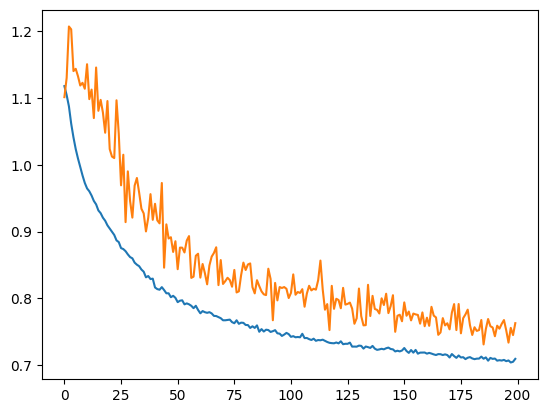

In [12]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [11]:
model.load_state_dict(best_weights)
torch.save(model.state_dict(), 'sis_autoencoder_finetuned.pt')